## Self-Organizing Maps

Os Mapas Auto-Organizáveis desenvolvidos por KOHONEN (1982) é uma rede neural, que imita o funcionamento do Córtex Cerebral, e se caracteriza por ser uma rede de camada única. A figura abaixo mostra a topografia da Rede Nueral, onde temos as amostras de entrada, a Rede Neural (Córtex) e os pesos conectando cada amostra a cada uma da Rede Nurônio.

<img src="./figures/latent_space.png"></img>

O treinamento do algoritmo Self Organization Maps (SOM) é normalmente dividido em dois estágios: competição, cooperação e adaptação. A figura abaixo mostra a dinâmica entre a rede SOM e as amostras (nuvem roxa).

Competição: nesta etapa é selecionado o neurônio vencedor com melhor correspondência em relação aos dados de entrada, (neurônio em amarelo forte na figura a);

Cooperação: a vizinhança do neurônio vencedor também é selecionado (região em amarelo claro na figura a);

Adaptação: aqui são adaptados os pesos do vencedor, bem como os dos neurônios vizinhos imediatos da rede, fazendo com que estes se aproximem da amostra (ponto branco na  figura b).

Após várias iterações, os Neurônios possuem novos pesos e a rede neural consegue representar as amostras, (figura c).



<img src="./figures/algorithm.png"></img>

                   (a)                             (b)                              (c)


## Algoritimo

O algoritmo SOM pode ser descrito nas seguintes etapas:

1. Inicialize os neurônios ($\mathbf{w}$) no espaço de parâmetros

2. Selecione uma amostra aleatória de dados ($\mathbf{x}$): $\mathbf{x}_n$

3. Encontre o neurônio mais semelhante a esta amostra, ou seja, a unidade de melhor correspondência (BMU - best-matching unit).

     $$BMU = \underset{j}{\arg \min} \left \| \mathbf{x}_n - \mathbf{w}_j \right \|$$

4. Ajuste os neurônios excitados:

     $$\Delta \mathbf{w}^{n} = \alpha(n) \cdot h(D(\mathbf{w}_{BMU},\mathbf{w}), n) \otimes (\mathbf{ x}_n - \mathbf{w}^{n})$$
     $$\mathbf{w}^{n+1} = \mathbf{w}^{n} + \Delta \mathbf{w}^{n}$$

5. Repita a partir do passo 2 até atingir o critério de parada

Onde $n$ é a etapa do algoritmo, $\alpha$ é a taxa de aprendizagem e $h$ é a função de vizinhança.


In [1]:
import numpy as np
from math import sqrt
import pandas as pd
import scipy as sp
from numpy.ma.core import ceil
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib import animation, colors
import Self_Organizing_Maps


In [2]:
# UTILIZAÇÃO DO APPYNHO PARA FAZER GRÁFICOS DE PERFIS:
#---------------------
import sys
sys.path.insert(0,'modules')
import imod
from appynho_2 import plotagem as plm2

# Etapa 1 -  Visualização dos dados de treinamento

### Etapa 1.1 - Carregamento do poço P1 para treinamento:

In [12]:
cab = ['etiquetas','prof','rhob', 'gr','res', 'vel']
data = pd.read_csv('syntetic_well_logging/arq_train.txt', sep='\s+',
                     skiprows=1, names = cab, usecols=(0,1,2,3,4,5) )

In [13]:
data

,etiquetas,prof,rhob,gr,res,vel
0,7.0,1.85,2.79,76.6,3.34,90.9
1,7.0,1.92,2.76,89.0,2.63,82.3
2,7.0,1.99,2.77,79.4,8.36,66.4
3,7.0,2.06,2.81,79.7,5.78,49.5
4,7.0,2.13,2.66,83.6,5.71,80.0
...,...,...,...,...,...,...
874,4.0,64.00,1.99,20.5,5.49,59.2
875,4.0,64.00,1.97,10.5,0.97,80.1
876,4.0,64.10,1.72,27.6,4.76,37.5
877,4.0,64.20,1.97,10.1,2.32,76.4


## Etapa 1.2 - Distribuição dos dados em crossplots e dos Perfis Geofísicos

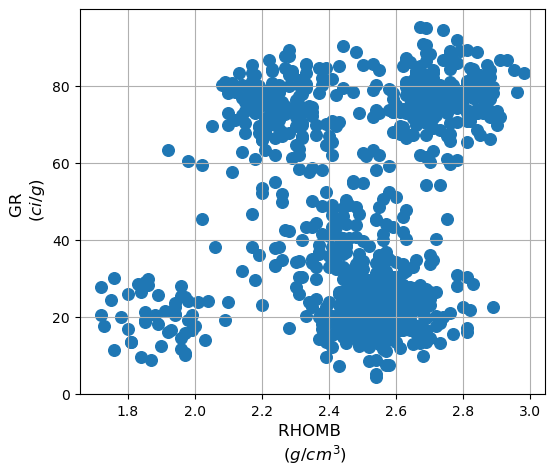

In [5]:
plt.close('all')
plt.figure(figsize=(6,5))

plt.scatter(data['rhob'], data['gr'], s=70, alpha=1.0) 

plt.xlabel('RHOMB \n $(g/cm^{3})$', fontsize = 12)
plt.ylabel('GR \n $(ci/g$)', fontsize = 12)
plt.grid(True)
plt.show()

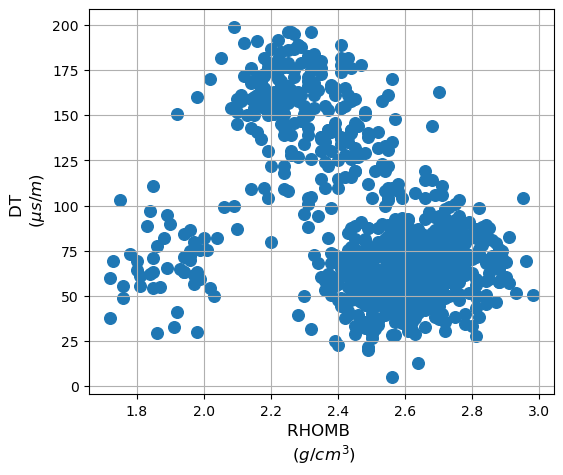

In [14]:
plt.close('all')
plt.figure(figsize=(6,5))

plt.scatter(data['rhob'], data['vel'], s=70, alpha=1.0) 

plt.xlabel('RHOMB \n $(g/cm^{3})$', fontsize = 12)
plt.ylabel('DT \n $(\mu s/m)$', fontsize = 12)
plt.grid(True)
plt.show()

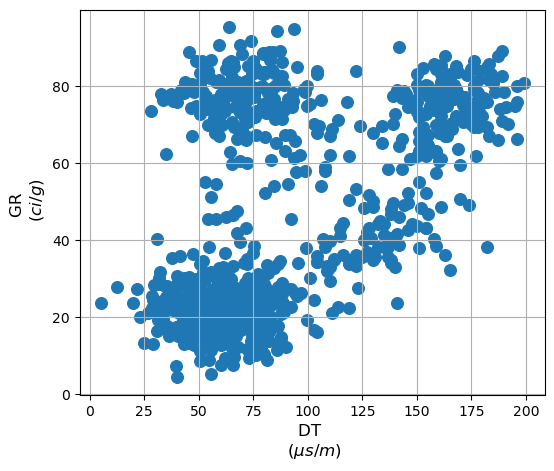

In [15]:
plt.close('all')
plt.figure(figsize=(6,5))

plt.scatter(data['vel'], data['gr'], s=70, alpha=1.0) 

plt.xlabel('DT \n $(\mu s/m)$', fontsize = 12)
plt.ylabel('GR \n $(ci/g$)', fontsize = 12)
plt.grid(True)
plt.show()

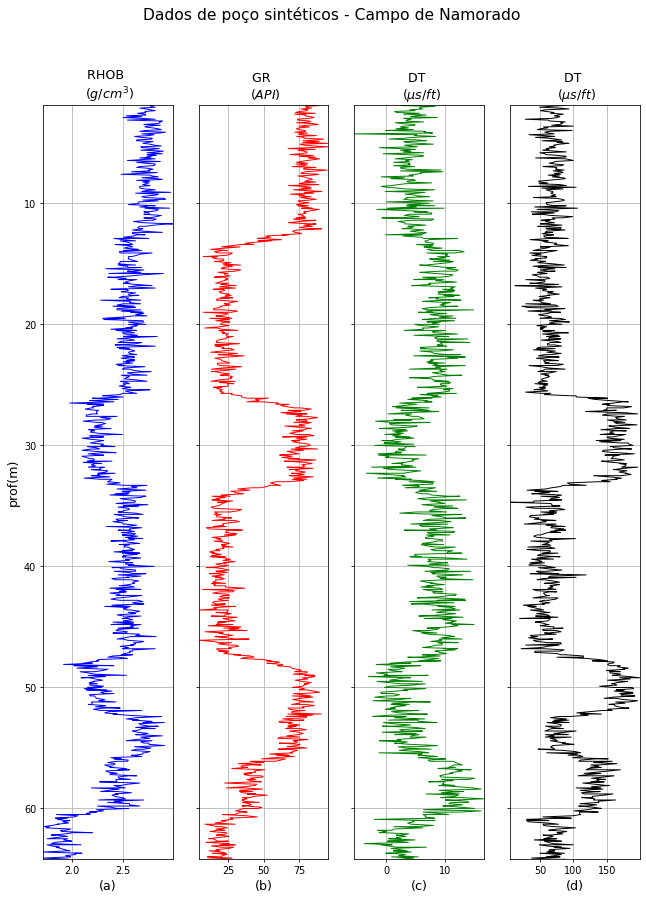

In [17]:
def order(x):
    """Cria uma lista começando do zero com o mesmo tamanho do dicionario"""
    r= [0]
    for i in range(x-1):
        i=i+1
        r.append(i)
    return r
    

# Gerando a imagem do poço

padrao={'comprimento':11,
            'altura':14,
        'titulo_geral': 'Dados de poço sintéticos - Campo de Namorado'
         }


#figure2 = plm2(3, padrao) 
figure2 = plm2(4, padrao)

figure2.plot_s(0,data['rhob'],data['prof'],
                   {'titulo':'RHOB \n $(g/cm^{3})$','cor':'b',
                    'descricao_y':'prof(m)',
                    'descricao_x':'(a)'})

figure2.plot_s(1,data['gr'],data['prof'],
                   {'titulo':'GR \n $(API)$','cor':'r','descricao_x':'(b)'})

figure2.plot_s(2,data['res'],data['prof'],
                   {'titulo':'DT \n $(\mu s/ft)$','cor':'g','descricao_x':'(c)'})

figure2.plot_s(3,data['vel'],data['prof'],
                   {'titulo':'DT \n $(\mu s/ft)$','cor':'k','descricao_x':'(d)'})


In [19]:
data_x = np.zeros((len(data), 4))
data_x.shape

(879, 4)

# Etapa 2 - Treinamento do Córtex

## Etapa 2.1 - Normalização dos dados e divisão em treinamento e rótulos:


In [20]:
data_x[:,0] = Self_Organizing_Maps.norm_data(data['rhob'])
data_x[:,1] = Self_Organizing_Maps.norm_data(data['gr'])
data_x[:,2] = Self_Organizing_Maps.norm_data(data['res'])
data_x[:,3] = Self_Organizing_Maps.norm_data(data['vel'])
data_x

array([[0.84920635, 0.79439252, 0.39547511, 0.44229479],
       [0.82539683, 0.93073117, 0.36334842, 0.39792602],
       [0.83333333, 0.82517867, 0.62262443, 0.31589537],
       ...,
       [0.        , 0.25563496, 0.45972851, 0.16679565],
       [0.1984127 , 0.06322155, 0.34932127, 0.36748697],
       [0.08730159, 0.26443101, 0.33122172, 0.43042873]])

In [21]:
data_y = np.array(data['etiquetas'])

In [22]:
# train and test split
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.25, random_state=42)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape) # check the shapes

(659, 4) (659,) (220, 4) (220,)


## Etapa 2.2 - Aplicação do Self-Organizing Maps nos dados "train" (utilização do arquivo ".py"):

In [51]:
# hyperparameters
n_rows = 12
n_cols = 12
max_distance = 2.5 #3
max_learning_rate = 1.2 # 1, 0.5
max_epochs = int(2500)
t = np.random.randint(0,high=train_x.shape[0]) # random index of traing data

#### SOM utilizando a mética Euclidiana e vizinhança Geussiana:

In [52]:
# "SOM_train" performs the competition, cooperation and updating
# of the neurons using the training data.
# It returns the weight of neurons updated after iterations, 
# stored in the variable "updated_som2".

updated_som = Self_Organizing_Maps.SOM_train(n_rows, 
                                              n_cols, 
                                              max_epochs, 
                                              max_learning_rate, 
                                              max_distance, 
                                              train_x, 
                                              train_y, 
                                              learn='linear', 
                                              neigh='gaussian', 
                                              metric='euclidian')

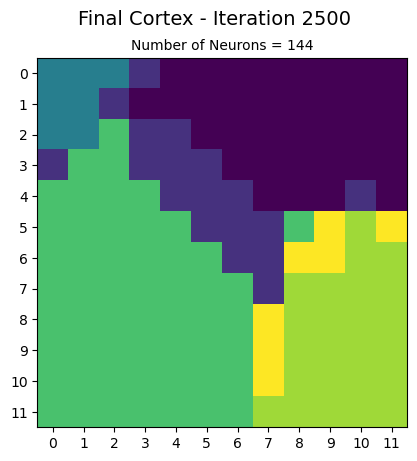

In [53]:
# "Cortex_map" shows the final Cortex showing the formed neighborhoods (same colors),
# using the adjusted weights "updated_som2"

label_map = Self_Organizing_Maps.Cortex_map(train_y, 
                                             train_x, 
                                             updated_som,
                                             max_epochs, 
                                             metric='euclidian')

In [54]:
# "SOM_class" classifies test data from step learning with "SOM_train". 
# Using association between neuron weight labels (updated_som2 + label_map2) and 
# test data property values (test_x).

index = Self_Organizing_Maps.SOM_class(test_x, 
                                        updated_som, 
                                        label_map, 
                                        metric='euclidian')

## Etapa 2.3 - Testando e avaliando os resultados do teste (arquivos test):

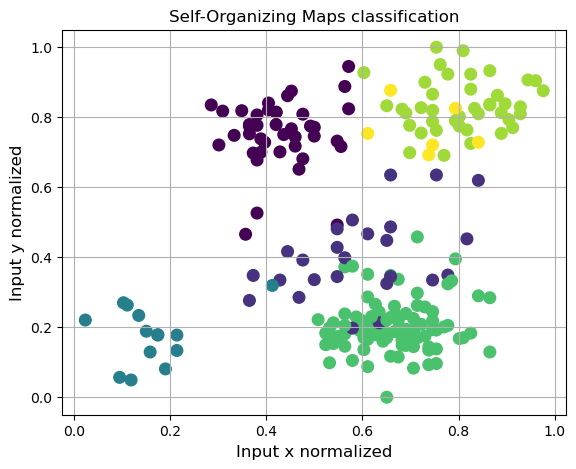

In [55]:
# "Crossplot" classification of data using two properties

Self_Organizing_Maps.Crossplot(index, test_x, 0, 1)

In [56]:
# Count of successes in percentage:

Self_Organizing_Maps.Per_count(test_y, index)

The count of successes in percentage is : 90.909.


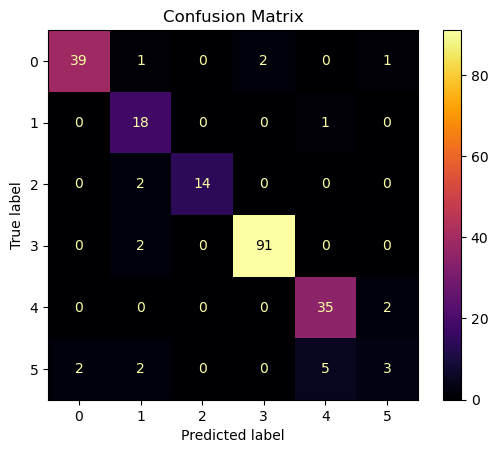

In [57]:
# "Confusion matrix" shows how well the test data was classified. 
# The more diagonal, means the better the classification 
# (comparison between actual and predicted labels)

conf_matrix = confusion_matrix(test_y, index)
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix) #, display_labels=ind)
vis.plot(cmap='inferno')
plt.title('Confusion Matrix')
plt.show()

# Etapa 3 - Classificação

## Etapa 3.1 - Carregamento do poço P2 para classificação:

In [58]:
cab = ['prof','rhob', 'gr','res', 'vel']
data_2 = pd.read_csv('syntetic_well_logging/arq_class.txt', sep='\s+',
                     skiprows=1, names = cab, usecols=(0,1,2,3,4) )

In [59]:
data_class = np.zeros((len(data_2), 4))
data_class.shape

(680, 4)

In [60]:
### Data normalization:

data_class[:,0] = Self_Organizing_Maps.norm_data(data_2['rhob'])
data_class[:,1] = Self_Organizing_Maps.norm_data(data_2['gr'])
data_class[:,2] = Self_Organizing_Maps.norm_data(data_2['res'])
data_class[:,3] = Self_Organizing_Maps.norm_data(data_2['vel'])
data_class

array([[0.86554622, 0.78677798, 0.28125   , 0.16638561],
       [0.85714286, 0.79354693, 0.52481618, 0.24732996],
       [0.85714286, 0.84769856, 0.40900735, 0.23327712],
       ...,
       [0.55462185, 0.38966606, 0.80698529, 0.62338392],
       [0.57983193, 0.47540614, 0.51148897, 0.67397414],
       [0.72268908, 0.41674188, 0.70128676, 0.54468803]])

## Etapa 3.2 - Usando os pesos dos Neurônios do Cortex da etapa de treinamento:

In [61]:
# Using "SOM_class" to classify test data. 
# The comparison is now made between the 
# weights and properties of the new well-log data

index = Self_Organizing_Maps.SOM_class(data_class, 
                                        updated_som, 
                                        label_map, 
                                        metric='euclidian')

## Etapa 3.3 - Visualização dos crossplots e perfil litológico após a classificação:

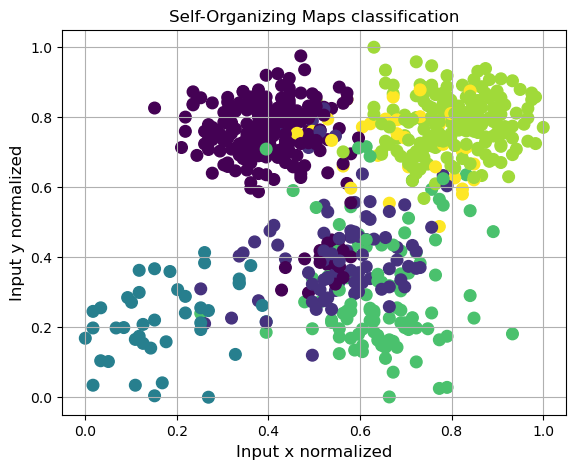

In [62]:
# "Crossplot" classification of data (well-log 2) using two properties 

Self_Organizing_Maps.Crossplot(index, data_class, 0, 1)

In [63]:
np.size(index)

680

#### Abaixo, uma imagem com os grupos originais formados pela modelagem de dados sintéticos para comparação:

In [64]:
from PIL import Image

image = Image.open('figures/RHOxGR_p2originaldisper.png')

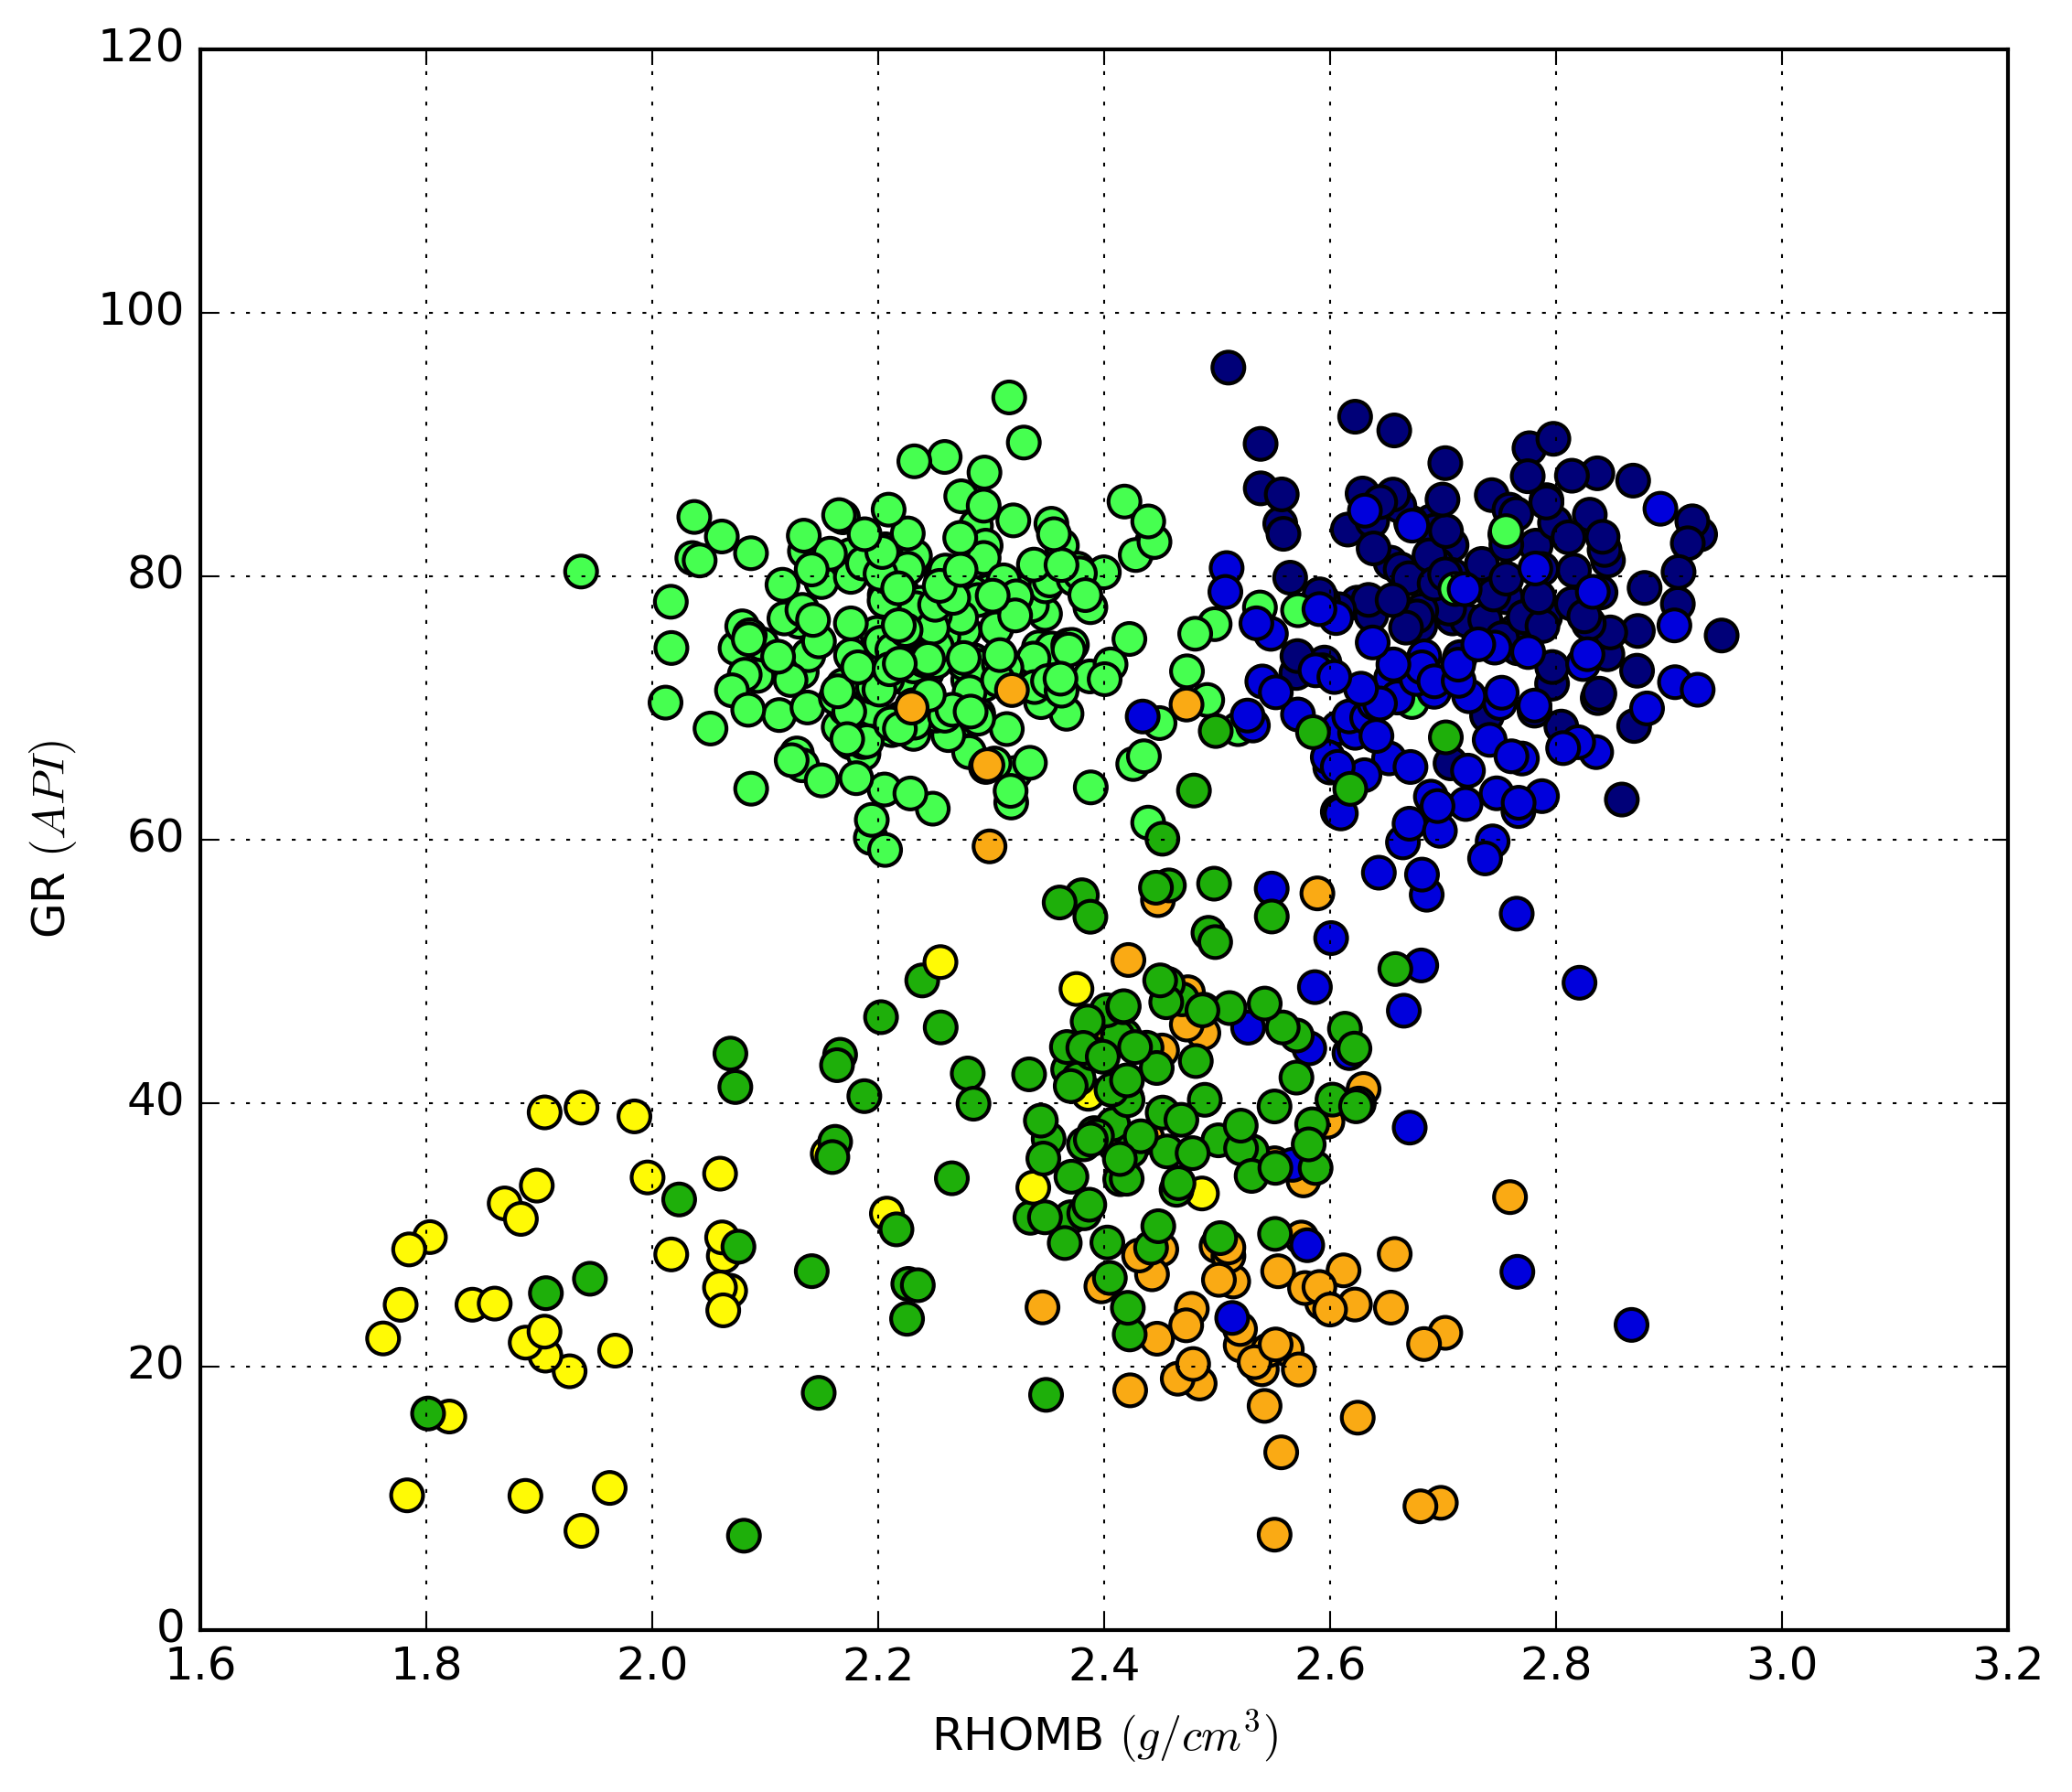

In [65]:
image

In [66]:
dicio = {7: ['#440154', 'label 0', 221,160,221, 255],
         6: ['#fde725', 'label 1', 153,50,204, 255],
         1: ['#3b528b', 'label 2', 0,0,128, 255], 
         8: ['#21908c', 'label 3', 75,0,130, 255], 
         2: ['#5dc863', 'label 4', 148,0,211, 255],
         4: ['#472d7b', 'label 5', 255,0,255, 255], 
         }

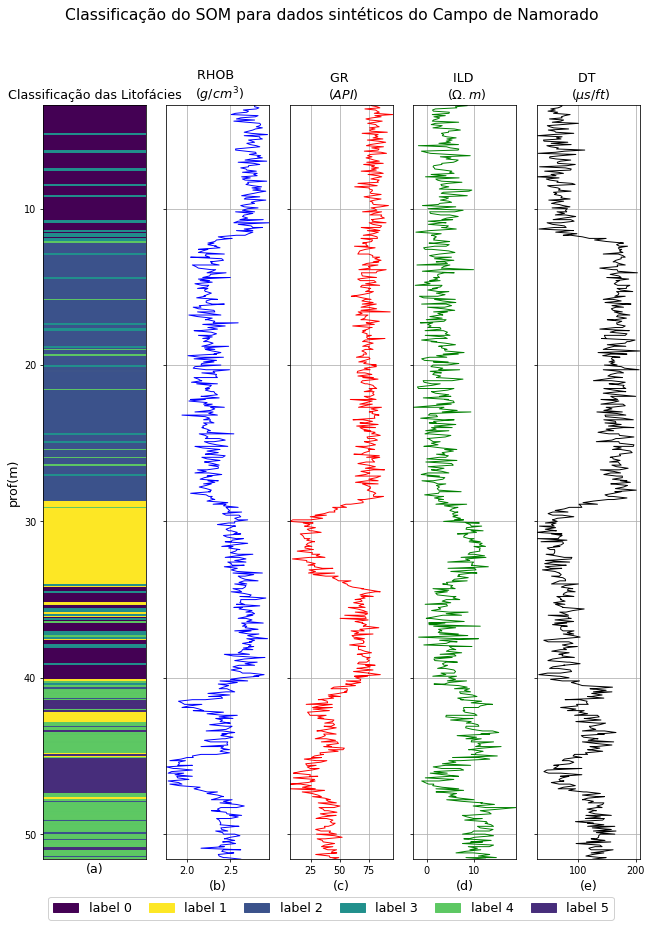

In [68]:
def order(x):
    """Cria uma lista começando do zero com o mesmo tamanho do dicionario"""
    r= [0]
    for i in range(x-1):
        i=i+1
        r.append(i)
    return r
    

padrao={'comprimento':11,
            'altura':14,
        'titulo_geral': 'Classificação do SOM para dados sintéticos do Campo de Namorado'
         }

figure2 = plm2(5, padrao) 

figure2.plot_l2(0,np.array(index), np.array(data_2['prof']), 
                dicio,{'titulo':'Classificação das Litofácies',
                       'descricao_y':'prof(m)','descricao_x':'(a)'})

figure2.plot_s(1,data_2['rhob'],data_2['prof'],
               {'titulo':'RHOB \n $(g/cm^{3})$','cor':'b','descricao_x':'(b)'})

figure2.plot_s(2,data_2['gr'],data_2['prof'],
               {'titulo':'GR \n $(API)$','cor':'r','descricao_x':'(c)'})

figure2.plot_s(3,data_2['res'],data_2['prof'],
               {'titulo':'ILD \n $(\Omega.m) $','cor':'g','descricao_x':'(d)'})

figure2.plot_s(4,data_2['vel'],data_2['prof'],
               {'titulo':'DT \n $(\mu s/ft)$','cor':'k','descricao_x':'(e)'})

figure2.legenda({'ancoragem':(0.05, 0.1, 5.5, -0.15),'colunas':6,'ordem':order(len(dicio)) })

plt.savefig('figures/perfil_classificado.png', dpi=300, bbox_inches = 'tight')
#, transparent = True)

#### Nota: aqui os rótulos são números de 0 a 5 mas, os rótulos podem ser codificações de litologias (Xisto, Arenito, ...)

### FIM